In [ ]:
%%capture --no-stderr
# %pip install --upgrade --quiet  langchain==0.2.17 langchain-community==0.2.17 langchainhub langchain-chroma bs4
# %pip install -qU langchain-openai==0.1.7
# !pip gradio_client>=0.16.1
# !pip install gradio>=4.44.0
%pip install -qU langchain langchain-community langchainhub langchain-chroma langchainhub langchain-openai langchain-classic gradio beautifulsoup4

In [ ]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass()

In [ ]:
from langchain_openai import ChatOpenAI
import bs4
import bs4
from langchainhub import Client
from langchain_classic.chains import create_retrieval_chain
from langchain_classic.chains.combine_documents import create_stuff_documents_chain
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [ ]:
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

In [ ]:
# 1. Load, chunk and index the contents of the blog to create a retriever.
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,
                                               chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())
retriever = vectorstore.as_retriever()

In [ ]:
# 2. Incorporate the retriever into a question-answering chain.
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

In [ ]:
#   "You are an assistant for question-answering tasks. "
#     "Use the following pieces of retrieved context to answer "
#     "the question. If you don't know the answer, say that you "
#     "don't know. Use three sentences maximum and keep the "
#     "answer concise."
#     "\n\n"

#     "LangChain is a framework that does ...."
#     "What should I used to productionize langchain"

In [ ]:
question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)
# retriever | prompt | llm

In [ ]:
response = rag_chain.invoke({"input": "What is Task Decomposition?"})
print("Response is\n------")
print(response["answer"])
# print(response["context"])

Response is
------
Task decomposition involves breaking down a complex task into smaller and simpler steps to make it more manageable. It helps in enhancing model performance on hard tasks by guiding the model to think step by step through a series of smaller subtasks. Different techniques like Chain of Thought and Tree of Thoughts are used to decompose tasks into simpler components for effective problem-solving.


# Adding History

In [ ]:
from langchain_classic.chains import create_history_aware_retriever  # as of 20251214, using classic -> this is an open issue with standard langchain library https://github.com/langchain-ai/langchain-community/issues/433
from langchain_core.prompts import MessagesPlaceholder

contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
# If there is no chat_history, then the input is just passed directly to the
# retriever. If there is chat_history, then the prompt and LLM will be used to
# generate a search query. That search query is then passed to the retriever.

# This chain prepends a rephrasing of the input query to our retriever,
# so that the retrieval incorporates the context of the conversation.

history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

In [ ]:
from langchain_classic.chains import create_retrieval_chain  # as of 20251214, using classic -> this is an open issue with standard langchain library https://github.com/langchain-ai/langchain-community/issues/433
from langchain_classic.chains.combine_documents import create_stuff_documents_chain

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

# history_aware_retriever and question_answer_chain in sequence, retaining
# intermediate outputs such as the retrieved context for convenience.
# It has input keys input and chat_history, and includes input, chat_history,
# context, and answer in its output.
rag_chain = create_retrieval_chain(history_aware_retriever,
                                   question_answer_chain)
#  contextualize_q_prompt | llm1 | retriver | qa_prpmt | llm2

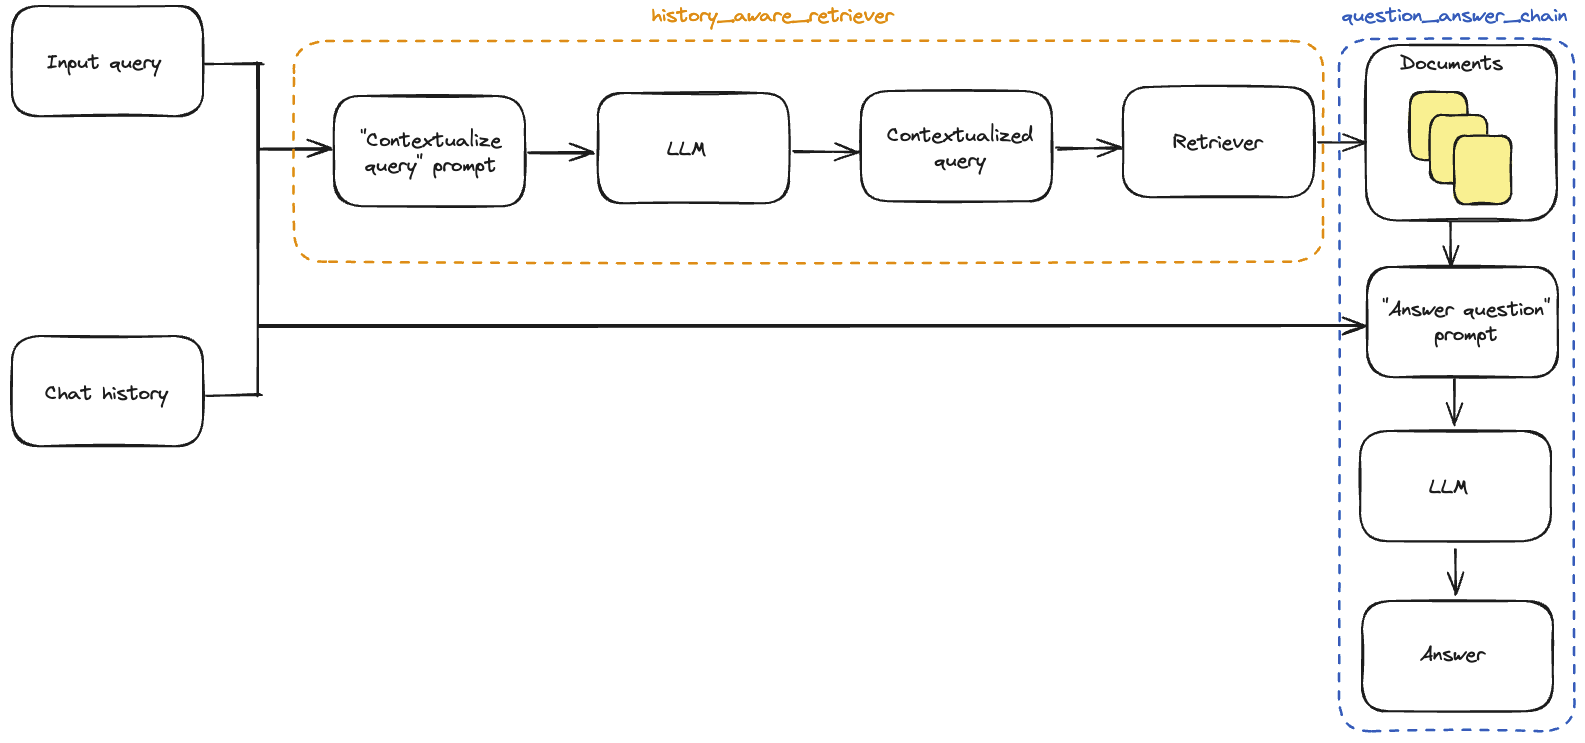

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage

chat_history = []

question = "What is Task Decomposition?"
ai_msg_1 = rag_chain.invoke({"input": question, "chat_history": chat_history})
chat_history.extend(
    [
        HumanMessage(content=question),
        AIMessage(content=ai_msg_1["answer"]),
    ]
)

second_question = "What are common ways of doing it?" # What are common ways of doing task decompsition
ai_msg_2 = rag_chain.invoke({"input": second_question, "chat_history": chat_history})

print(ai_msg_2["answer"])

Task decomposition can be achieved in several ways, such as using Language Model (LLM) with simple prompting, task-specific instructions, or human inputs. Additionally, the LLM+P approach involves relying on an external classical planner to perform long-horizon planning using the Planning Domain Definition Language (PDDL) as an intermediate interface. This method outsources the planning step to an external tool, assuming the availability of domain-specific PDDL and a suitable planner, which is common in certain robotic setups.


# Gradio

In [ ]:
import gradio as gr

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage

def predict(question, chat_history):
  history_for_llm = []
  for tup in chat_history:
    history_for_llm.extend([HumanMessage(tup[0]), AIMessage(tup[1])])

  ai_msg = rag_chain.invoke({"input": question, "chat_history": history_for_llm})
  return ai_msg["answer"]

In [ ]:
demo = gr.ChatInterface(
    fn=predict,
    chatbot=gr.Chatbot(height=300),
    textbox=gr.Textbox(
        placeholder="Hi I am your virtual assistant, how can I help you today?",
        container=False,
        scale=7
    ),
    title="DocumentQABot",
    examples=["What is the weather like in SF?", "What is LangSmith?"],
)
demo.launch(share=True, debug=True)  # Theme 'soft' is default

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ba4c7e4bc1aea2cff7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.12/dist-packages/gradio/routes.py:1350: DeprecationWarning: 'HTTP_422_UNPROCESSABLE_ENTITY' is deprecated. Use 'HTTP_422_UNPROCESSABLE_CONTENT' instead.
  return await queue_join_helper(body, request, username)
/usr/local/lib/python3.12/dist-packages/gradio/routes.py:1350: DeprecationWarning: 'HTTP_422_UNPROCESSABLE_ENTITY' is deprecated. Use 'HTTP_422_UNPROCESSABLE_CONTENT' instead.
  return await queue_join_helper(body, request, username)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ba4c7e4bc1aea2cff7.gradio.live
